# Import và hàm vẽ

In [ ]:
import numpy as np
import timeit
import pandas as pd
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import tqdm
import sklearn
from sklearn import datasets
from sklearn import svm

In [ ]:
def myplot(X, y, w, b, filename, tit):
    with PdfPages(filename) as pdf:
        fig, ax = plt.subplots()

        w0 = w[0][0]
        w1 = w[0][1]
        x1 = np.arange(-10, 10, 0.1)
        y1 = -w0/w1*x1 - b/w1
        y2 = -w0/w1*x1 - (b-1)/w1
        y3 = -w0/w1*x1 - (b+1)/w1
        plt.plot(x1, y1, 'k', linewidth = 3)
        plt.plot(x1, y2, 'k')
        plt.plot(x1, y3, 'k')

        # equal axis and lim
        plt.axis('equal')
        plt.ylim(0, 4.5)
        plt.xlim(0, 6)

        # hide tikcs 
        cur_axes = plt.gca()
        cur_axes.axes.get_xaxis().set_ticks([])
        cur_axes.axes.get_yaxis().set_ticks([])

        # fill two regions
        y4 = 10*x1
        plt.plot(x1, y1, 'k')

        plt.xlabel('$x_1$', fontsize = 20)
        plt.ylabel('$x_2$', fontsize = 20)
        plt.title('Solution found by ' + tit, fontsize = 20)

        plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')
        pdf.savefig()
        plt.show()

# 1. Bài toán SVM biên cứng

## Dữ liệu

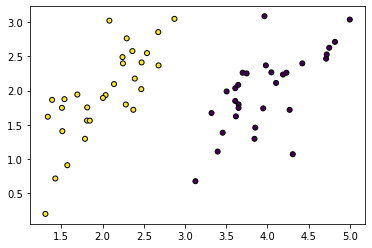

In [ ]:
from __future__ import print_function
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(22)

means = [[2, 2], [4, 2]]
cov = [[.3, .2], [.2, .3]]
N = 30
n = 60
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X = np.concatenate((X0, X1), axis = 0)
y = np.concatenate((np.ones((N, 1)), -1*np.ones((N, 1))), axis = 0)
# plot points
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')
plt.show()

Dữ liệu gồm 60 điểm chia đều cho 2 class mỗi class 30 điểm

In [ ]:
pip install qpsolvers

Do google colab không có sẵn qpsolvers nên cài thêm vào

##Biên cứng cài bằng sklearn

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', C = 1e5) # just a big number 
ys = y.reshape((60,))
clf.fit(X, ys ) # each sample is one row

w_sklearn = clf.coef_
b_sklearn = clf.intercept_
print('w = ', w_sklearn)
print('b = ', b_sklearn)


w =  [[-2.08715576  0.94509035]]
b =  [4.35333677]


## Biên cứng theo bài toán gốc

In [ ]:
from cvxopt import matrix, solvers
from qpsolvers import solve_qp
G0 =  np.vstack((-X0.T[0],-X0.T[1],-np.ones(N))).T
G1 =  np.vstack(( X1.T[0], X1.T[1], np.ones(N))).T
G = np.concatenate((G0, G1), axis = 0)
h = -np.ones((n,))
P = np.array([[1,0,0],[0,1,0],[0,0,0]],dtype=np.float64)
q = np.zeros((3,))
S = solve_qp(P,q,G,h,solver='cvxopt')
w_primal = S[:2]
w_primal = w_primal.reshape(1,2)
b_primal = S[2]
print('w =', w_primal)
print('b =', b_primal)

w = [[-2.08686629  0.9453558 ]]
b = 4.351744859057347


##Biên cứng theo bài toán đối ngẫu

In [ ]:
from cvxopt import matrix, solvers
# build P
V = np.concatenate((X0, -X1), axis = 0)
P = matrix(V.dot(V.T))
q = matrix(-np.ones((n, 1)))

# build A, b, G, h 
G = matrix(-np.eye(n))
h = matrix(np.zeros((n, 1)))
A = matrix(y.T) 
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False
S = solvers.qp(P, q, G, h, A, b)
l = np.array(S['x'])
w_dual = matrix(np.zeros((1,2)))
SV = 0
e = 1e-6
b_dual = 0
for i in range(0,n):
  if l[i] > e:
    SV = SV + 1
    w_dual = w_dual + l[i]*V[i]
for i in range(0,n):
  if l[i] > e:
    b_dual = b_dual + (y[i]-w_dual.dot(X[i]))
b_dual = b_dual / SV
print('w = ', w_dual)
print('b = ', b_dual)

w =  [[-2.08686613  0.94535566]]
b =  [4.34573119]


## Hình minh họa

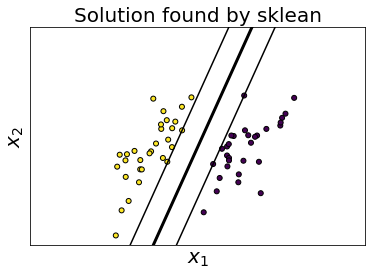

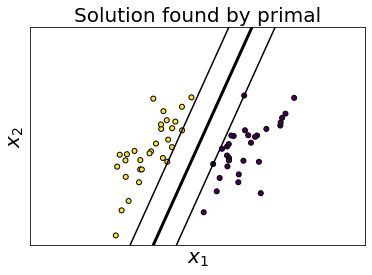

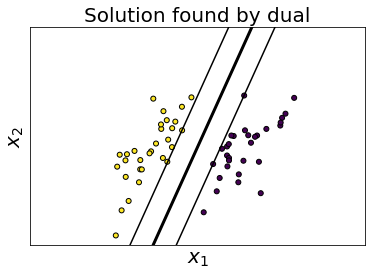

In [ ]:
myplot(X,y,w_sklearn,b_sklearn,'hard_sklean.pdf','sklean')
myplot(X,y,w_primal,b_primal,'hard_primal.pdf','primal')
myplot(X,y,w_dual,b_dual,'hard_sklean.pdf','dual')

# 2. Bài toán SVM biên mềm

## Dữ liệu

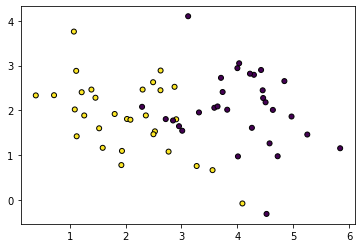

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# list of points 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.backends.backend_pdf import PdfPages
np.random.seed(22)

means = [[2, 2], [4, 2]]
cov = [[.7, 0], [0, .7]]
N = 30
n = 60
X0 = np.random.multivariate_normal(means[0], cov, N) 
X1 = np.random.multivariate_normal(means[1], cov, N)
X = np.vstack((X0, X1))
y = np.vstack((np.ones((N,1)), -np.ones((N,1)))).reshape((2*N,))

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')
plt.show()

Gồm 60 điểm chia đều cho 2 class mỗi class 30 điểm

## Bài toán biên mềm bằng sklearn

In [ ]:
c = 100
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', C = c)
clf.fit(X, y) 
w_sklearn = clf.coef_
b_sklearn = clf.intercept_
print('w = ', w_sklearn)
print('b = ', b_sklearn)

w =  [[-2.29323939 -0.90196918]]
b =  [9.08544668]


## Bài toán biên mềm theo bài toán gốc

In [ ]:
from cvxopt import matrix, solvers
from qpsolvers import solve_qp
#build G
c = 100
G0 =  np.vstack((-X0.T[0],-X0.T[1],-np.ones(N))).T
G1 =  np.vstack(( X1.T[0], X1.T[1], np.ones(N))).T
G = np.concatenate((G0, G1), axis = 0)
G2 = np.zeros((n,3))
G = np.concatenate((G,G2),axis = 0)
I = -np.eye(n)
I = np.concatenate((I,I),axis = 0)
G = np.concatenate((G,I),axis = 1)
#build h q P
h = np.concatenate((-np.ones((n,1)),np.zeros((n,1))),axis = 0)
q = np.concatenate((np.zeros((3,1)),c*np.ones((n,1))),axis = 0)
P = np.zeros((n+3,n+3))
P[0][0] = P[1][1] = 1
S = solve_qp(P,q,G,h,solver='cvxopt')
w_primal = S[:2].reshape((1,2))
b_primal = S[2]
print('w = ', w_primal)
print('b = ', b_primal)

w =  [[-2.29478114 -0.9030211 ]]
b =  9.092452515195498


## Bài toán biên mềm theo bài toán Đối ngẫu

In [ ]:
from cvxopt import matrix, solvers
c = 100

# build P
V = np.concatenate((X0, -X1), axis = 0)
P = matrix(V.dot(V.T))
q = matrix(-np.ones((n, 1)))

# build A, b, G, h 
G = matrix(np.vstack((-np.eye(n), np.eye(n))))
h = matrix(np.concatenate((np.zeros((n, 1)),c*np.ones((n,1))),axis = 0))
A = matrix(y.reshape((n,1)).T) 
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False
S = solvers.qp(P, q, G, h, A, b)
l = np.array(S['x'])
w_dual = matrix(np.zeros((1,2)))
SV = 0
e = 1e-5
b_dual = 0

for i in range(0,n): 
  if l[i] > e:
    w_dual = w_dual + l[i]*V[i]

for i in range(0,n):
  if l[i] > e and c-l[i] > e:
    SV = SV + 1
    b_dual = b_dual + (y[i]-w_dual.dot(X[i]))
b_dual = b_dual / SV
print('w = ', w_dual)
print('b = ', b_dual)

w =  [[-2.29476522 -0.90301443]]
b =  [9.08907348]


## Hình minh họa 

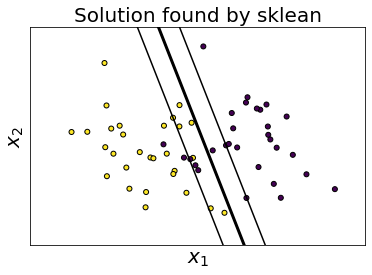

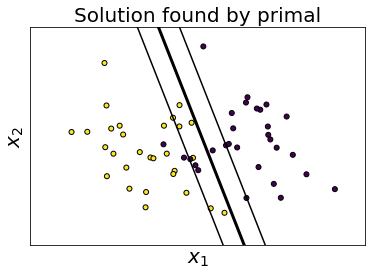

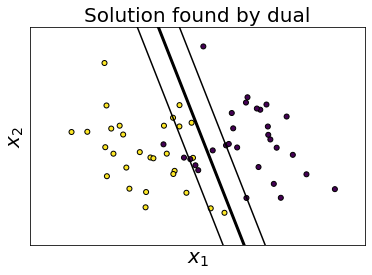

In [ ]:
myplot(X,y,w_sklearn,b_sklearn,'hard_sklean.pdf','sklean')
myplot(X,y,w_primal,b_primal,'hard_primal.pdf','primal')
myplot(X,y,w_dual,b_dual,'hard_sklean.pdf','dual')

# 3. Tham khảo

https://github.com/tiepvupsu/tiepvupsu.github.io/blob/master/assets/19_svm/plt/SVM-example.ipynb
https://github.com/tiepvupsu/tiepvupsu.github.io/blob/master/assets/20_softmarginsvm/plt/softmargin%20SVM%20Example.ipynb
